In [23]:
l = k.to_rooted_tree(0)

In [28]:
p = l.breadth_first_traversal()[0]


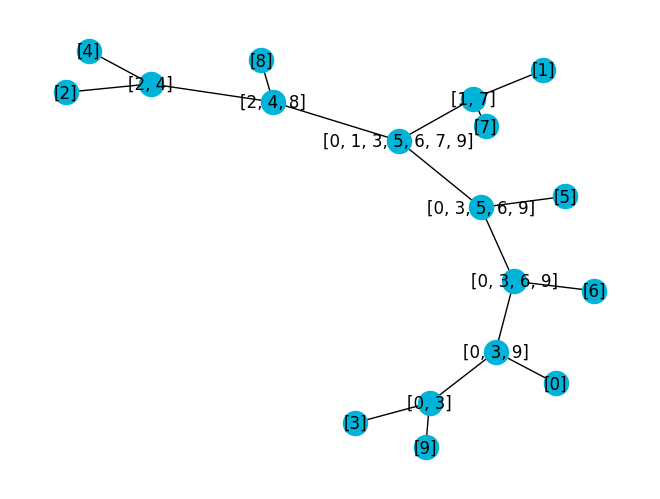

In [22]:
import pickle
import torch
import networkx as nx
with open('phylo_parsimony/20240211_032215_DS1_partial/best_trees.pt', 'rb') as file:
    tree = pickle.load(file)

k = tree[12]
gr  = l.nx_graph
pos = nx.spring_layout(gr)
nx.draw(gr, node_color='#00b4d9', pos=pos, with_labels=True)


In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

import torch
from tqdm import tqdm
import numpy as np
import datetime
import pickle
import random
from docopt import docopt

import shutil
import gzip
import time
from datetime import timedelta
from src.utils.logging import get_logger
from src.configs.defaults import get_cfg_defaults
from src.env.build import build_env
from src.gfn.gfn_evaluation import GFNEvaluator
from src.gfn.rollout_worker_phylo import RolloutWorker
from src.gfn.training_data_loader import TrainingDataLoader
from src.gfn.build import build_gfn
from src.utils.utils import load_sequences, load_seqs_cfg_data
from src.utils.resources_setup import get_list_of_devices
from heapq import heappushpop, heappush
import networkx as nx
from copy import deepcopy
from src.utils.utils import display_trajectory
from src.env.binary_tree_env_one_step_likelihood import *
from src.utils.utils import process_trajectories_tb
from scipy.stats import pearsonr

In [2]:
from scipy.stats import pearsonr
from matplotlib import pyplot as plt

In [2]:
def nx_to_tree(nx_graph, env):
    """
    convert nx graph to unrooted tree
    """
    nx_graph = deepcopy(nx_graph)
    nodes = nx_graph.nodes
    nb_nodes = len(nx_graph.nodes)  # leafs and internal nodes
    nb_leaves = nb_nodes // 2 + 1
    root_id = nb_nodes
    edge_0 = list(nx_graph.edges(0))[0]
    edge_length = nx_graph.edges[edge_0]['t']
    node_1_id, node_2_id = edge_0
    edge_length_half = edge_length / 2

    nx_graph.add_node(root_id, type='internal')

    nx_graph.remove_edge(node_1_id, node_2_id)
    nx_graph.add_edge(node_1_id, root_id, t=edge_length_half)
    nx_graph.add_edge(node_2_id, root_id, t=edge_length_half)

    for node_id in nx.dfs_postorder_nodes(nx_graph, source=root_id):
        node = nodes[node_id]
        if node['type'] == 'leaf':
            tree = PhyloTree(env.evolution_model, at_root=False,
                             root_seq_data=[env.seq_arrays[node_id], [node_id]])
        else:
            neighbor_nodes = nx.neighbors(nx_graph, node_id)
            children_indices = [x for x in neighbor_nodes if 'rooted_tree' in nx_graph.nodes[x]]
            child_nodes = [(nei_id, nx_graph.nodes[nei_id]['rooted_tree']) for nei_id in children_indices]
#             print(node_id, len(child_nodes ))
            child_nodes = sorted(child_nodes, key=lambda x: x[1].min_seq_index)
            left_key = (child_nodes[0][0], node_id)
            right_key = (child_nodes[1][0], node_id)
            left_length = nx_graph.edges[left_key]['t']
            right_length = nx_graph.edges[right_key]['t']

            left_length = np.ceil(left_length / 0.001) * 0.001
            right_length = np.ceil(right_length / 0.001) * 0.001
            left_length = max(left_length, cfg.GFN.MODEL.EDGES_MODELING.CATEGORICAL.BIN_SIZE )
            right_length = max(right_length, cfg.GFN.MODEL.EDGES_MODELING.CATEGORICAL.BIN_SIZE)
            left_length = min(left_length, cfg.GFN.MODEL.EDGES_MODELING.CATEGORICAL.BIN_SIZE* cfg.GFN.MODEL.EDGES_MODELING.CATEGORICAL.BINS)
            right_length = min(right_length, cfg.GFN.MODEL.EDGES_MODELING.CATEGORICAL.BIN_SIZE* cfg.GFN.MODEL.EDGES_MODELING.CATEGORICAL.BINS)
            tree = PhyloTree(env.evolution_model,
                             at_root=(node_id == root_id),
                             left_tree_data={'tree': child_nodes[0][1], 'branch_length': left_length},
                             right_tree_data={'tree': child_nodes[1][1], 'branch_length': right_length})

        node['rooted_tree'] = tree
    tree = tree.to_unrooted_tree()
    return tree


In [3]:
def plot_scatter_save(results, output):
    
    fig,axis = plt.subplots(2,3, figsize=(13, 6.5))
    axis[0, 0].scatter(results['0_random']['gfn']['sample_p'], results['0_random']['gfn']['r'], alpha=0.5)
    axis[0, 0].title.set_text('GFN on 0% random trees')

    axis[0, 1].scatter(results['30_random']['gfn']['sample_p'], results['30_random']['gfn']['r'], alpha=0.5)
    axis[0, 1].title.set_text('GFN on 30% random trees')
    axis[0, 2].scatter(results['50_random']['gfn']['sample_p'], results['50_random']['gfn']['r'], alpha=0.5)
    axis[0, 2].title.set_text('GFN on 50% random trees')

    axis[1, 0].scatter(results['0_random']['vbpi_gnn']['sample_p'], results['0_random']['vbpi_gnn']['r'], alpha=0.5)
    axis[1, 0].title.set_text('VBPI-GNN on 0% random trees')
    axis[1, 1].scatter(results['30_random']['vbpi_gnn']['sample_p'], results['30_random']['vbpi_gnn']['r'], alpha=0.5)
    axis[1, 1].title.set_text('VBPI-GNN on 30% random trees')
    axis[1, 2].scatter(results['50_random']['vbpi_gnn']['sample_p'], results['50_random']['vbpi_gnn']['r'], alpha=0.5)
    axis[1, 2].title.set_text('VBPI-GNN on 50% random trees')
#     for a in axis.flat:
#         a.set_box_aspect(1)
    for idx, ax in enumerate(axis.flat):
        if idx in (0,3):
            ax.set(ylabel='Unnormalized \n Log Posterior Density')
        if idx in (3,4,5):
            ax.set(xlabel='Sampling Log Density')
        ax.axis('equal')  
#     plt.tight_layout()
#     fig.tight_layout(pad=1.0)


    plt.savefig(output, dpi=350, bbox_inches="tight")  
    plt.show()

# Load model

In [4]:

model_path = 'phylo_parsimony/20240211_032215_DS1_partial/'
cfg_path = 'CONFIG_PATH'
sequences_path = 'dataset/benchmark_datasets/DS1.pickle'


cfg = get_cfg_defaults()
cfg.set_new_allowed(True)
cfg.merge_from_file(cfg_path)
# cfg.ENV.EVOLUTION_MODEL.COMPUTE_PRIOR = True
all_seqs = load_sequences(sequences_path)

cfg = load_seqs_cfg_data(all_seqs, cfg)

verbose = True
nb_device =   1
enable_ags = False
dataloader_device, generator_devices = get_list_of_devices(nb_device, enable_ags)

all_seqs = load_sequences(sequences_path)
env, state2input = build_env(cfg, all_seqs)
rollout_worker = RolloutWorker(cfg.GFN, env, state2input)
generator = build_gfn(cfg, state2input, env, generator_devices)
generator.load(model_path)


# Compute MLL

In [11]:
cfg_eval = cfg.GFN.MODEL.EVALUATION
gfn_evaluator = GFNEvaluator(cfg_eval, rollout_worker, generator, states=None, verbose=True,
                             scales_set=None)
gfn_evaluator.evaluate_marginal_likelihood_z(num_trajs=1024)


Total trajectories MLL estimation progress: 100%|█| 1024/1024 [00:49


{'marginal_likelihood': -7108.995644873939}

# Compute log sampling density vs log posterior density

load trees from vbpi-gnn output

In [13]:
vbpi_trees_path = '/user/vbpi-gnn/vbpi_gnn_ds1_0_trees_result.p'


In [22]:
from src.env.binary_tree_env_one_step_likelihood import PhylogeneticTreeState
num_trees = len(env.seq_arrays)
bin_size = env.edge_env.categorical_bin_size
discrete_factor = - (num_trees * 2 - 3) * np.log(bin_size)
tree_factor = - np.sum(np.log(np.arange(3, 2 * num_trees - 3, 2)))


cfg_eval = cfg.GFN.MODEL.EVALUATION
vbpi_trees = pickle.load(open(vbpi_trees_path, 'rb'))
trees = [nx_to_tree(x, env) for x in vbpi_trees['nx_trees']]
states = [PhylogeneticTreeState([tree]) for tree in trees]
gfn_evaluator = GFNEvaluator(cfg_eval, rollout_worker, generator, states=states, verbose=True,
                             scales_set=None)


In [48]:

def aggregate_pearsonr_result(cfg, generator, env, vbpi_trees_path):
    
    
    num_trees = len(env.seq_arrays)
    bin_size = env.edge_env.categorical_bin_size
    discrete_factor = - (num_trees * 2 - 3) * np.log(bin_size)
    tree_factor = - np.sum(np.log(np.arange(3, 2 * num_trees - 3, 2)))

    
    cfg_eval = cfg.GFN.MODEL.EVALUATION
    vbpi_trees = pickle.load(open(vbpi_trees_path, 'rb'))
    trees = [nx_to_tree(x, env) for x in vbpi_trees['nx_trees']]
    states = [PhylogeneticTreeState([tree]) for tree in trees]
    gfn_evaluator = GFNEvaluator(cfg_eval, rollout_worker, generator, states=states, verbose=True,
                                 scales_set=None)
    logp, rewards = gfn_evaluator.estimate_gfn_states_sampling_probs(states, 1.0)    
    
    result= {
        'gfn': {
            'sample_p': logp + discrete_factor ,
            'r': rewards + tree_factor - env.reward_fn.C
        },
        'vbpi_gnn': {
            'sample_p':vbpi_trees['vbpi_sampling_p'],
            'r': vbpi_trees['vbpi_prior_likelihood']
        }
    }
    result['gfn_pearsonr'] = pearsonr(logp+ discrete_factor , rewards +tree_factor).statistic
    
    result['vbpi_pearsonr'] = vbpi_trees['vbpi_pearson_r']
    return result

In [37]:
os.mkdir('example_vbpignn_ds1_result')

Total trajectories pearsonr evaluation progress:   0%| | 0/16384 [00/user/phylo_gfn/src/env/binary_tree_env_one_step_likelihood.py:574: RuntimeWarning: overflow encountered in exp
  reward = np.exp(log_reward)
/user/phylo_gfn/src/env/binary_tree_env_one_step_likelihood.py:574: RuntimeWarning: overflow encountered in exp
  reward = np.exp(log_reward)
/user/phylo_gfn/src/env/binary_tree_env_one_step_likelihood.py:574: RuntimeWarning: overflow encountered in exp
  reward = np.exp(log_reward)
/user/phylo_gfn/src/env/binary_tree_env_one_step_likelihood.py:574: RuntimeWarning: overflow encountered in exp
  reward = np.exp(log_reward)
/user/phylo_gfn/src/env/binary_tree_env_one_step_likelihood.py:574: RuntimeWarning: overflow encountered in exp
  reward = np.exp(log_reward)
/user/phylo_gfn/src/env/binary_tree_env_one_step_likelihood.py:574: RuntimeWarning: overflow encountered in exp
  reward = np.exp(log_reward)
/user/phylo_gfn/src/env/binary_tree_env_one_step_likelihood.py:574: RuntimeWarni

GFN 0_random pearson_r 0.9942504211989474
VBPI-GFN 0_random pearson_r 0.9547924426065574
GFN 30_random pearson_r 0.9599151426917236
VBPI-GFN 30_random pearson_r 0.5888386451058258
GFN 50_random pearson_r 0.9584093525586301
VBPI-GFN 50_random pearson_r 0.5123631868393136


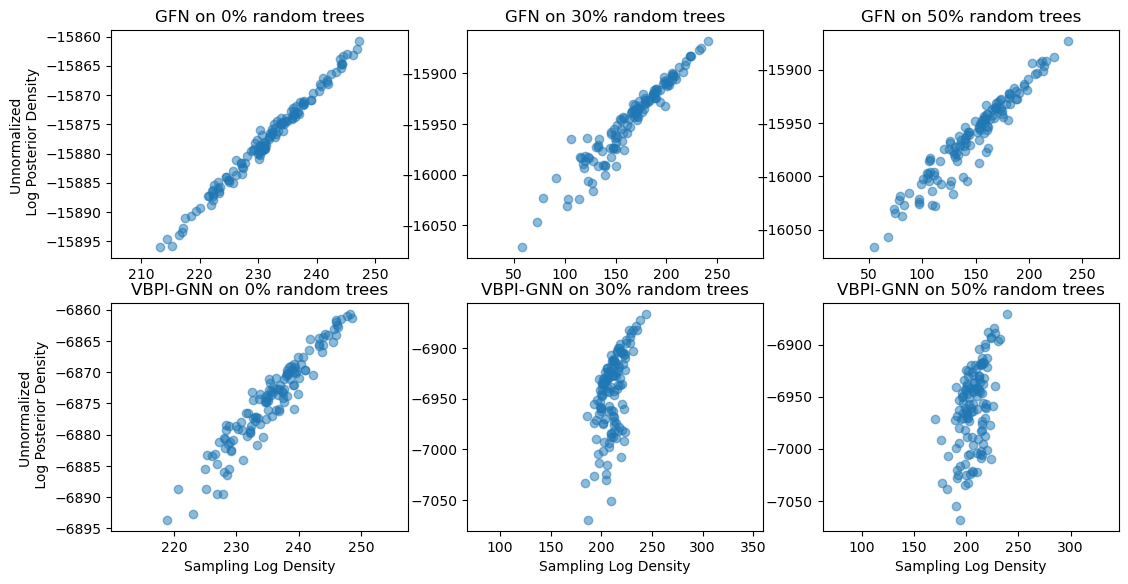

In [50]:
ds1_result = {}
path = 'example_vbpignn_ds1_result/vbpi_gnn_ds1_0_trees_result.p'
ds1_result['0_random'] = aggregate_pearsonr_result(cfg, generator, env, path)
path = 'example_vbpignn_ds1_result/vbpi_gnn_ds1_30_trees_result.p'
ds1_result['30_random'] = aggregate_pearsonr_result(cfg, generator, env, path)
path = 'example_vbpignn_ds1_result/vbpi_gnn_ds1_50_trees_result.p'
ds1_result['50_random'] = aggregate_pearsonr_result(cfg, generator, env, path)


for key in ds1_result.keys():
    print('GFN {} pearson_r {}'.format(key, ds1_result[key]['gfn_pearsonr']))
    print('VBPI-GFN {} pearson_r {}'.format(key, ds1_result[key]['vbpi_pearsonr']))

plot_scatter_save(ds1_result, 'ds1_pearsonr_g.pdf')